In [61]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [62]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [63]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [64]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [65]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)


/var/folders/nc/s5pb_20n2q1_pc86ltqkwhjw0000gp/T/ipykernel_78088/2639776237.py:4: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [66]:
# View all of the classes that automap found
print(Base.classes.keys())

['measurement', 'station']


In [67]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [68]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [69]:
# Find the most recent date in the data set.
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

print(most_recent_date)


('2017-08-23',)


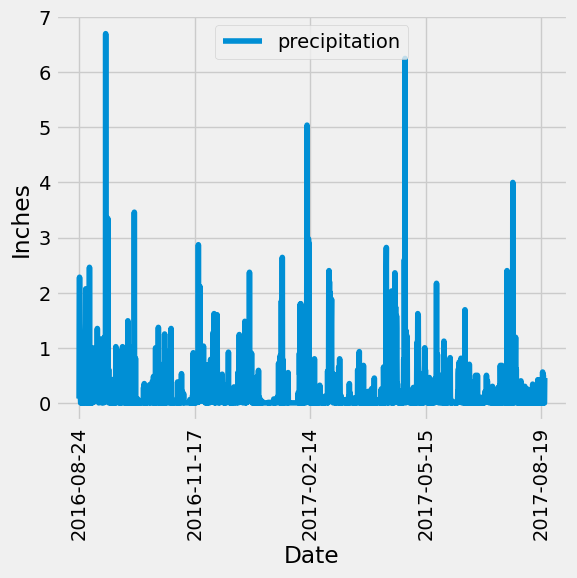

In [70]:
# Find the most recent date in the data set
most_recent_date_row = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
most_recent_date = most_recent_date_row.date

# Calculate the date one year from the last date in dataset
most_recent_datetime = dt.datetime.strptime(most_recent_date, "%Y-%m-%d")
one_year_ago = most_recent_datetime - dt.timedelta(days=365)

# Perform a query to retrieve the date and precipitation scores for the last 12 months
precip_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= one_year_ago).all()

# Save the query results as a Pandas DataFrame and explicitly set the column names
precip_df = pd.DataFrame(precip_data, columns=['date', 'precipitation'])

# Sort the DataFrame by date
precip_df = precip_df.sort_values(by='date')

# Set the date as the DataFrame index
precip_df.set_index('date', inplace=True)

# Drop NaN values
precip_df.dropna(inplace=True)

# Plot the data using Pandas Plotting with Matplotlib
precip_df.plot(figsize=(6, 6))
plt.xlabel('Date')
plt.ylabel('Inches')
plt.xticks(rotation=90) 
plt.legend(loc='upper center')
plt.tight_layout()
plt.show()

In [71]:
# Use Pandas to calculate the summary statistics for the precipitation data
precip_summary = precip_df.describe()
print(precip_summary)

       precipitation
count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000


# Exploratory Station Analysis

In [72]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Station.station)).scalar()

print(total_stations)

9


In [73]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.station).label('count')).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()
for station, count in active_stations:
    print(station, count)

USC00519281 2772
USC00519397 2724
USC00513117 2709
USC00519523 2669
USC00516128 2612
USC00514830 2202
USC00511918 1979
USC00517948 1372
USC00518838 511


In [74]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = session.query(Measurement.station).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).first()[0]

# Query to calculate the lowest, highest, and average temperature for the most active station
temperature_stats = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == most_active_station).all()

print(temperature_stats[0][0] , temperature_stats[0][1], temperature_stats[0][2] )

54.0 85.0 71.66378066378067


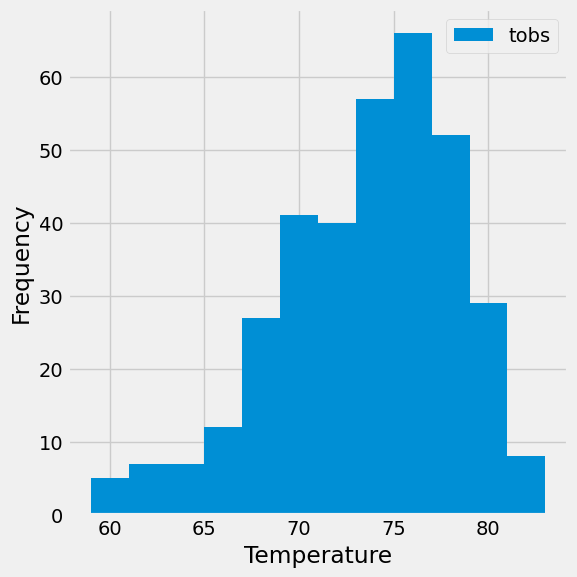

In [75]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temperature_data = session.query(Measurement.tobs).\
    filter(Measurement.station == most_active_station).\
    filter(Measurement.date >= one_year_ago).all()
temperature_df = pd.DataFrame(temperature_data, columns=['tobs'])

plt.figure(figsize=(6,6))
plt.hist(temperature_df['tobs'], bins=12)
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.legend(['tobs'], loc='best')
plt.tight_layout()
plt.show()

# Close Session

In [76]:
# Close Session
session.close()

In [79]:
from flask import Flask, jsonify
app = Flask(__name__)

# Define routes
@app.route("/")
def home():
    """Homepage"""
    return (
        f"Welcome to the Hawaii Climate Analysis API!<br/>"
        f"Available Routes:<br/>"
        f"/api/v1.0/precipitation<br/>"
        f"/api/v1.0/stations<br/>"
        f"/api/v1.0/tobs<br/>"
        f"/api/v1.0/&lt;start&gt;<br/>"
        f"/api/v1.0/&lt;start&gt;/&lt;end&gt;"
    )

@app.route("/api/v1.0/precipitation")
def precipitation():
    """Return the precipitation data for the last 12 months"""
    # Calculate the date one year ago from the last date in dataset
    most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first().date
    one_year_ago = dt.datetime.strptime(most_recent_date, "%Y-%m-%d") - dt.timedelta(days=365)
    
    # Query precipitation data for the last 12 months
    precipitation_data = session.query(Measurement.date, Measurement.prcp).\
        filter(Measurement.date >= one_year_ago).all()
    
    # Convert the query results to a dictionary
    precipitation_dict = {date: prcp for date, prcp in precipitation_data}
    
    return jsonify(precipitation_dict)

@app.route("/api/v1.0/stations")
def stations():
    """Return a list of stations"""
    # Query all stations
    stations = session.query(Station.station).all()
    
    # Convert the query results to a list
    station_list = [station for station, in stations]
    
    return jsonify(station_list)

@app.route("/api/v1.0/tobs")
def tobs():
    """Return temperature observations for the most active station for the previous year"""
    # Find the most active station
    most_active_station = session.query(Measurement.station).\
        group_by(Measurement.station).\
        order_by(func.count(Measurement.station).desc()).first()[0]
    
    # Calculate the date one year ago from the last date in dataset
    most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first().date
    one_year_ago = dt.datetime.strptime(most_recent_date, "%Y-%m-%d") - dt.timedelta(days=365)
    
    # Query temperature observations for the most active station for the previous year
    tobs_data = session.query(Measurement.date, Measurement.tobs).\
        filter(Measurement.station == most_active_station).\
        filter(Measurement.date >= one_year_ago).all()
    
    # Convert the query results to a list of dictionaries
    tobs_list = [{"date": date, "tobs": tobs} for date, tobs in tobs_data]
    
    return jsonify(tobs_list)

@app.route("/api/v1.0/<start>")
def start_date(start):
    """Return minimum, average, and maximum temperatures for all dates greater than or equal to the start date"""
    # Query temperature data for dates greater than or equal to the start date
    temp_data = session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start).all()
    
    # Convert the query results to a list of dictionaries
    temp_list = [{"Min Temp": temp[0], "Avg Temp": temp[1], "Max Temp": temp[2]} for temp in temp_data]
    
    return jsonify(temp_list)

@app.route("/api/v1.0/<start>/<end>")
def start_end_date(start, end):
    """Return minimum, average, and maximum temperatures for dates between the start and end dates"""
    # Query temperature data for dates between the start and end dates
    temp_data = session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start).\
        filter(Measurement.date <= end).all()
    
    # Convert the query results to a list of dictionaries
    temp_list = [{"Min Temp": temp[0], "Avg Temp": temp[1], "Max Temp": temp[2]} for temp in temp_data]
    
    return jsonify(temp_list)

if __name__ == "__main__":
    app.run(debug=True)

 * Serving Flask app '__main__'
 * Debug mode: on


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
 * Restarting with watchdog (fsevents)
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.11/site-packages/ipykernel_launcher.py", line 15, in <module>
    from ipykernel import kernelapp as app
  File "/opt/anaconda3/lib/python3.11/site-packages/ipykernel/__init__.py", line 7, in <module>
    from .connect import *
  File "/opt/anaconda3/lib/python3.11/site-packages/ipykernel/connect.py", line 12, in <module>
    import jupyter_client
  File "/opt/anaconda3/lib/python3.11/site-packages/jupyter_client/__init__.py", line 3, in <module>
    from .asynchronous import AsyncKernelClient
  File "/opt/anaconda3/lib/python3.11/site-packages/jupyter_client/asynchronous/__init__.py", line 1, in <module>
    from .client import AsyncKernelClient  # noqa
    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.11/site-packages/jupyter_client/asynchronous/client.py", line 11, in <module>
    from ..chann

SystemExit: 1